In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

import matplotlib.pyplot as plt

# --- Configuration ---
#INPUT_BANDS = 2500
#N_SAMPLES = 5000 # Example total samples
BATCH_SIZE = 32
EPOCHS = 500 # Set a large number, EarlyStopping will find the best
LEARNING_RATE = 1e-4
PATIENCE = 30 # For Early Stopping
IGNORE_VALUE = -1 # Integer value to represent 'N' or ignored labels

# Task names (consistent keys/output layer names)
# Note: Plant is now both an intermediate feature AND a final output
TASK_NAMES = ['plant', 'age', 'part', 'health', 'lifecycle']
OUTPUT_NAMES = [f"{task}_output" for task in TASK_NAMES]

# Loss weights (weighting between tasks, start equal)
LOSS_WEIGHTS = {
    'plant_output': 1.0, # Plant code still needs a loss
    'age_output': 1.0,
    'part_output': 1.0,
    'health_output': 1.0,
    'lifecycle_output': 1.0
}

print(f"Using TensorFlow version: {tf.__version__}")
# Optional: Configure GPU memory growth if needed
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Configured memory growth for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(e)

2025-05-02 15:15:16.187418: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 15:15:16.627031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-02 15:15:16.866211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-02 15:15:16.947231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 15:15:17.382053: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow version: 2.17.0
Configured memory growth for 1 GPU(s)


I0000 00:00:1746198927.409913     995 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746198927.811192     995 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746198927.811360     995 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Load the UPWINS spectral library and metadata csv

## Load full spectral library

In [2]:
import sys
sys.path.append('util/')
import importlib

import util_scripts as util

import os
from dotenv import load_dotenv

from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

MONGO_DBR_URI = os.getenv('MONGO_DBR_URI')

In [ ]:
importlib.reload(util)

In [3]:
reload_data_driver = False

if (reload_data_driver):

    records = []

    # Create a new client and connect to the server
    client = MongoClient(MONGO_DBR_URI, server_api=ServerApi('1'))

    # Send a ping to confirm a successful connection
    try:
        client.admin.command('ping')
        print("Pinged your deployment. You successfully connected to MongoDB!")
    except Exception as e:
        print(e)

    db = client["upwins_db"]
    view_name = "spectral_library"
    spectral_library = db[view_name]

    records = spectral_library.find()

    df = pd.DataFrame(records)
    df.to_pickle('data/pkl/library.pkl')

else:
    df = pd.read_pickle('data/pkl/library.pkl')

In [4]:
sc = util.SpectralCollection(df)
wl_lib = sc.wl
name = sc.name
spectra = sc.spectra

## Open Nano imagery

In [5]:
import spectral

fname = 'data/4-24-2025/100128_Allied_04_24_2025_2015_06_04_18_03_34/raw_0_ref'

# Open the image and read into an array
im = spectral.envi.open(fname+'.hdr', fname)
wl_img = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
print(f'Shape of Im.Arr = {im.Arr.shape}')
im.List = np.reshape(im.Arr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of im.List = {im.List.shape}')
dataList = im.List[np.sum(im.List, axis=1)>0, :]
print(f'Shape of dataList = {dataList.shape}')
nr = im.nrows
nc = im.ncols
nb = im.nbands

Shape of Im.Arr = (1998, 408, 272)
Shape of im.List = (815184, 272)
Shape of dataList = (815180, 272)


In [9]:
print(wl_lib.shape)
print(wl_img.shape)

print(wl_img)

(2151,)
(272,)
[ 399.60645307  401.82729662  404.04814017  406.26898373  408.48982728
  410.71067083  412.93151438  415.15235793  417.37320148  419.59404503
  421.81488858  424.03573214  426.25657569  428.47741924  430.69826279
  432.91910634  435.13994989  437.36079344  439.581637    441.80248055
  444.0233241   446.24416765  448.4650112   450.68585475  452.9066983
  455.12754185  457.34838541  459.56922896  461.79007251  464.01091606
  466.23175961  468.45260316  470.67344671  472.89429026  475.11513382
  477.33597737  479.55682092  481.77766447  483.99850802  486.21935157
  488.44019512  490.66103867  492.88188223  495.10272578  497.32356933
  499.54441288  501.76525643  503.98609998  506.20694353  508.42778708
  510.64863064  512.86947419  515.09031774  517.31116129  519.53200484
  521.75284839  523.97369194  526.19453549  528.41537905  530.6362226
  532.85706615  535.0779097   537.29875325  539.5195968   541.74044035
  543.9612839   546.18212746  548.40297101  550.62381456  552.84

## Resample library

In [7]:
# Create a BandResampler, which is a function that resamples spectra from one source to match a different source.
# See: https://www.spectralpython.net/class_func_ref.html?highlight=resampling#spectral.algorithms.resampling.BandResampler
# Inputs: the first input is the wavelengths for the spectra that you are going to resample, the second input is the wavelengths that you want to resample to.
resampler = spectral.BandResampler(wl_lib, wl_img)
spectra_resampled = resampler(spectra.T).T

print(f'The shape of the spectral library is {spectra_resampled.shape}.')
print(f'({spectra_resampled.shape[0]} spectra with {spectra_resampled.shape[1]} bands.)')

spectra = spectra_resampled

The shape of the spectral library is (5179, 272).
(5179 spectra with 272 bands.)


## Optional filtering

In [ ]:
filter = {
    'name': 'Chasmanthium_latifolium',
    #'fname': '',
    #'genus': '',
    #'species': '',
    'age': 'M',
    'health': 'H',
    'part': 'L',
    #'type': '',
    #'lifecycle': '',
    #'date': ''
}

prediction_class = 'age'

selected_indices = sc.select_indicies_with_filter(filter)

nSpec = len(selected_indices)
print(f"Number of Spectra: {nSpec}")

print(sc.age[selected_indices])
print(sc.principle_part[selected_indices])

In [ ]:
means = {}
class_spectra = spectra[selected_indices]
class_nSpec = class_spectra.shape[0]

plt.figure(figsize=(10,6)) 
for i in range(class_nSpec):
    plt.plot(wl,class_spectra[i,:].flatten(), color='b', alpha=0.05)
means[filter['name']] = np.mean(class_spectra, axis=0)
plt.plot(wl, means[filter['name']], color='r')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title(f'Spectra for {filter['name']}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True)

# Prepare the data for training and testing

In [ ]:
# # Old assignments

# # Assemble X and Y for training
# X_o = spectra
# Yn_o = sc.name
# Yg_o = sc.genus
# Ys_o = sc.species
# Ypp_o = sc.principle_part
# Yh_o = sc.health
# Ya_o = sc.age
# Yl_o = sc.lifecycle
# Yd_o = sc.DateTimeId
# Ym_o = sc.month
# Yngs_o = sc.name_genus_species
# Ynfc_o = sc.name_full_category
# Ypt_o = sc.plant_type
# print(X_o.shape,Yn_o.shape)
# #print(f'Number of genus: {len(np.unique(Yg_o))}: {np.unique(Yg_o)}\n')
# #print(f'Number of species: {len(np.unique(Ys_o))}: {np.unique(Ys_o)}\n')
# print(f'Number of principle_parts: {len(np.unique(Ypp_o))}: {np.unique(Ypp_o)}\n')
# print(f'Number of health categories: {len(np.unique(Yh_o))}: {np.unique(Yh_o)}\n')
# print(f'Number of age categories: {len(np.unique(Ya_o))}: {np.unique(Ya_o)}\n')
# print(f'Number of lifecycle categories: {len(np.unique(Yl_o))}: {np.unique(Yl_o)}\n')
# #print(f'Number of Date-Time_Id values: {len(np.unique(Yd_o))}\n')
# #print(f'Number of months: {len(np.unique(Ym_o))}: {np.unique(Ym_o)}\n')
# print(f'Number of names: {len(np.unique(Yn_o))}: {np.unique(Yn_o)}\n')
# #print(f'Number of name_genus_species categories: {len(np.unique(Yngs_o))}: {np.unique(Yngs_o)}\n')
# #print(f'Number of name_full_categories: {len(np.unique(Ynfc_o))}\n')
# #print(f'Number of plant types: {len(np.unique(Ypt_o))}: {np.unique(Ypt_o)}\n')

## Prepare ROI data for training

In [8]:
## Prepare ROI data; Append to spectra array and 5 primary labeled arrays

import pickle
import os

def find_roi_files(root_dir):
    string_list = ['.pkl', 'roi']
    
    matching_files = []
    for root, _, files in os.walk(root_dir):
        for filename in files:
            if all(string in filename.lower() for string in string_list):
                matching_files.append(os.path.join(root, filename))
    return matching_files


In [9]:
# codes for species with information and health\growth-stage\etc..
plant_codes = {
    'Ammo_bre': ['Ammophila', 'breviligulata', 'American Beachgrass', 'grass', 'https://en.wikipedia.org/wiki/Ammophila_breviligulata'],
    'Chas_lat': ['Chasmanthium', 'latifolium', 'River Oats', 'grass', 'https://en.wikipedia.org/wiki/Chasmanthium_latifolium'],
    'Pani_ama': ['Panicum', 'amarum', 'Coastal Panic Grass', 'grass', 'https://en.wikipedia.org/wiki/Panicum_amarum'],
    'Pani_vir': ['Panicum', 'virgatum', 'Switch Grass', 'grass', 'https://en.wikipedia.org/wiki/Panicum_virgatum'],
    'Soli_sem': ['Solidago', 'sempervirens', 'Seaside Goldenrod', 'succulent', 'https://en.wikipedia.org/wiki/Chasmanthium_latifolium'],
    'Robi_his': ['Robinia', 'hispida', 'Bristly locust', 'shrub', 'https://en.wikipedia.org/wiki/Robinia_hispida'],
    'More_pen': ['Morella', 'pennsylvanica', 'Bristly locust', 'shrub', 'https://en.wikipedia.org/wiki/Myrica_pensylvanica'],    
    'Rosa_rug': ['Rosa', 'rugosa', 'Sandy Beach Rose', 'shrub', 'https://en.wikipedia.org/wiki/Rosa_rugosa'],
    'Cham_fas': ['Chamaecrista', 'fasciculata', 'Partridge Pea', 'legume', 'https://en.wikipedia.org/wiki/Chamaecrista_fasciculata'],
    'Soli_rug': ['Solidago', 'rugosa', 'Wrinkleleaf goldenrod', 'shrub', 'https://en.wikipedia.org/wiki/Solidago_rugosa'],
    'Bacc_hal': ['Baccharis', 'halimifolia', 'Groundseltree', 'shrub', 'https://en.wikipedia.org/wiki/Baccharis_halimifolia'],
    'Iva_fru_': ['Iva', 'frutescens', 'Jesuits Bark ', 'shrub', 'https://en.wikipedia.org/wiki/Iva_frutescens'],
    'Ilex_vom': ['Ilex', 'vomitoria', 'Yaupon Holly', 'evergreen shrub', 'https://en.wikipedia.org/wiki/Ilex_vomitoria']
}  
age_codes = {  
    'PE': ['Post Germination Emergence', 'PE'],
	#'RE': ['Re-emergence', 'RE'],
    #'RE': ['Year 1 growth', '1G'],
	#'E': ['Emergence (from seed)', 'E'],
    'E': ['Post Germination Emergence', 'PE'],
	#'D': ['Dormant', 'D'],
	'1G': ['Year 1 growth', '1G'],
    '2G': ['Year 2 growth', '2G'],
	#'1F': ['Year 1 Flowering', '1F'],
    'J': ['Juvenile', 'J'],
	'M': ['Mature', 'M']
}
principal_part_codes = {  
    'MX': ['Mix', 'MX'],
    #'S': ['Seed', 'SE'],
	#'SA': ['Shoot Apex', 'SA'],
    'SA': ['Internode Stem', 'ST'],
	'L': ['Leaf/Blade', 'L'],
	#'IS': ['Internode Stem', 'IS'],
    'ST': ['Internode Stem', 'ST'],
    'SP': ['Sprout', 'SP'],
	#'CS': ['Colar Sprout', 'CS'],
    'CS': ['Sprout', 'SP'],
	#'RS': ['Root Sprout', 'RS'],
    'RS': ['Sprout', 'SP'],
	'LG': ['Lignin', 'LG'],
	'FL': ['Flower', 'FL'],
    #'B': ['Blade', 'B'],
	'B': ['Leaf/Blade', 'L'],
    'FR': ['Fruit', 'FR'],
	#'S': ['Seed', 'SE'], #moved above because 'S' is in other codes; this is an old code
    'SE': ['Seed', 'SE'],
	#'St': ['Stalk', 'St']
}
health_codes = {
    'MH': ['Healthy/Unhealthy Mix', 'MH'],
	'DS': ['Drought Stress', 'DS'],
	'SS': ['Salt Stress (soak)', 'SS'],
    'SY': ['Salt Stress (spray)', 'SY'],
	'S': ['Stressed', 'S'],
    'LLRZ': ['LLRZ Lab Stress', 'LLRZ'],
	#'D': ['Dormant', 'D'],
    'R': ['Rust', 'R'],
    'H': ['Healthy', 'H']
}

lifecycle_codes = { 
	'D': ['Dormant', 'D'],
    'RE': ['Re-emergence', 'RE'],
    'FLG': ['Flowering', 'FLG'],
    'FRG': ['Fruiting', 'FRG'],
    "FFG": ['Fruiting and Flowering', 'FFG'],
    'N': ['Neither', 'N']
}

# data lists

d_spectra = []
d_plant = []
d_part = []
d_health = []
d_age = []
d_lifecycle = []

yd_all_dict = {
    'plant': d_plant,
    'age': d_age,
    'part': d_part,
    'health': d_health,
    'lifecycle': d_lifecycle
}

code_category_dict = {
    'plant': plant_codes,
    'age': age_codes,
    'part': principal_part_codes,
    'health': health_codes,
    'lifecycle': lifecycle_codes
}

In [10]:
roi_files = find_roi_files('data/pkl/rois/')

print(f"Number of ROI files found: {len(roi_files)}")

for roi_filename in roi_files:
   # Unpickling the dictionary
    with open(roi_filename, 'rb') as f:
        roiData = pickle.load(f)
        roi_df = roiData.df # a DataFrame holding all the data for the ROI

    roi_spectra = roi_df.to_numpy()[:,4:]
    roi_spectra = roi_spectra.astype(np.float32)
    roi_spectra_names = roi_df['Name'].to_numpy()

    roi_names = roiData.names # the names of the ROIs

    print(f"Number of ROIs found in {roi_filename}: {len(roi_names)}")

    for name in roi_names:
        roi_class_spectra = roi_spectra[roi_spectra_names==name]

        if name[-1] != '_':
            name = name + '_'

        # parse name for metadata
        class_data_dict = {}          
        
        for cat, codes in code_category_dict.items():
            class_data_dict[cat] = '-1'
            for key, value in codes.items():
                if cat == 'plant':
                    if name[:8].lower()==key.lower():
                        class_data_dict[cat] = value[0] + '_' + value[1]
                else:
                    if '_'+key+'_' in name:
                        #print(f'here: {name}')
                        class_data_dict[cat] = value[1]
                        #print(key, class_data_dict[cat])
                        #print(class_data_dict)

        #print(class_data_dict)

        # for each spectrum in class_spectra, append to each list
        for roi_spectrum in roi_class_spectra:

            d_spectra.append(roi_spectrum)
            
            for key in yd_all_dict:
                #print(key)
                #print(len(yd_all_dict[key]))
                #print(yd_all_dict[key])
                yd_all_dict[key].append(class_data_dict[key])
                #print(len(yd_all_dict[key]))


Number of ROI files found: 1
Number of ROIs found in data/pkl/rois/ROIs_4-25_Ilex_vom.pkl: 2


In [11]:
d_spectra = np.asarray(d_spectra)
print(d_spectra.shape)

for key in yd_all_dict:
    yd_all_dict[key] = np.asarray(yd_all_dict[key])
    print(key, yd_all_dict[key].shape)

(2506, 272)
plant (2506,)
age (2506,)
part (2506,)
health (2506,)
lifecycle (2506,)


In [12]:
spectra = np.concatenate((spectra, d_spectra))

sc.name = np.concatenate((sc.name, d_plant))
sc.age = np.concatenate((sc.age, d_age))
sc.principle_part = np.concatenate((sc.principle_part, d_part))
sc.health = np.concatenate((sc.health, d_health))
sc.lifecycle = np.concatenate((sc.lifecycle, d_lifecycle))

## Prepare data for training and testing

In [13]:
def assign_integer_labels(data_array, label_array):
    """
    Assigns integer values from a label array to corresponding values in a data array.

    Args:
        data_array:  The array containing the string or categorical data (e.g., Yn_o, Ypp_o, etc.).
        label_array: The array of unique labels (e.g., y_plant_labels, y_part_labels, etc.).

    Returns:
        A NumPy array containing the integer representations of the data based on the labels.
    """
    mapping = {label: i for i, label in enumerate(label_array)}
    integer_array = np.array([mapping[x] for x in data_array])
    return integer_array


X_all = spectra

y_plant_labels = np.unique(sc.name)
y_part_labels = np.unique(sc.principle_part)
y_health_labels = np.unique(sc.health)
y_age_labels = np.unique(sc.age)
y_lifecycle_labels = np.unique(sc.lifecycle)

# Number of classes for each task
n_plant_classes = len(y_plant_labels)
n_age_classes = len(y_age_labels)
n_part_classes = len(y_part_labels)
n_health_classes = len(y_health_labels)
n_lifecycle_classes = len(y_lifecycle_labels)

Yn_int = assign_integer_labels(sc.name, y_plant_labels)
Yp_int = assign_integer_labels(sc.principle_part, y_part_labels)
Yh_int = assign_integer_labels(sc.health, y_health_labels)
Ya_int = assign_integer_labels(sc.age, y_age_labels)
Yl_int = assign_integer_labels(sc.lifecycle, y_lifecycle_labels)

In [14]:
def replace_n_with_ignore_val(integer_array, label_array):
    """
    Replaces integer values with -1 in an integer array where the corresponding
    label in the label array is 'N'.

    Args:
        integer_array: The integer-encoded data array (e.g., Yn_int, Ypp_int, etc.).
        label_array: The array of unique labels (e.g., y_plant_labels, y_part_labels, etc.).

    Returns:
        A NumPy array with values replaced by -1 where the label is 'N'.
    """
    try:
        n_index = np.where(label_array == 'N')[0][0]  # Find the index of 'N'
        integer_array[integer_array == n_index] = IGNORE_VALUE  # Replace values
        return integer_array
    except IndexError:
        print("'N' not found in the label array.  No replacements made.")
        return integer_array


y_plant = replace_n_with_ignore_val(Yn_int, y_plant_labels)
y_part = replace_n_with_ignore_val(Yp_int, y_part_labels)
y_age = replace_n_with_ignore_val(Ya_int, y_age_labels)
y_health = replace_n_with_ignore_val(Yh_int, y_health_labels)

y_lifecycle = Yl_int

y_all_dict_original = {'plant': y_plant, 'part': y_part, 'age': y_age, 'health': y_health, 'lifecycle': y_lifecycle}


'N' not found in the label array.  No replacements made.


In [15]:
# --- Data Splitting (Train/Validation/Test on features and ORIGINAL labels) ---
indices = np.arange(len(X_all))
train_indices, test_indices = train_test_split(indices, test_size=0.15, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.1765, random_state=42)
X_train, X_val, X_test = X_all[train_indices], X_all[val_indices], X_all[test_indices]
y_train_dict_orig = {task: y_all_dict_original[task][train_indices] for task in TASK_NAMES}
y_val_dict_orig = {task: y_all_dict_original[task][val_indices] for task in TASK_NAMES}
y_test_dict_orig = {task: y_all_dict_original[task][test_indices] for task in TASK_NAMES}
print(f"Data split sizes: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

Data split sizes: Train=5379, Val=1153, Test=1153


In [16]:
# --- Preprocessing (Standardization) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Reshape for Conv1D: (batch, steps, channels=1) ---
X_train_scaled = X_train_scaled[..., np.newaxis]
X_val_scaled = X_val_scaled[..., np.newaxis]
X_test_scaled = X_test_scaled[..., np.newaxis]
#X_train_scaled = X_train[..., np.newaxis]
#X_val_scaled = X_val[..., np.newaxis]
#X_test_scaled = X_test[..., np.newaxis]

print(f"Feature shapes: Train={X_train_scaled.shape}, Val={X_val_scaled.shape}, Test={X_test_scaled.shape}")

# --- Prepare Labels for Keras Fit/Evaluate (Replace IGNORE_VALUE with 0) ---
y_train_dict_keras = {f"{task}_output": np.maximum(0, y_train_dict_orig[task]) for task in TASK_NAMES}
y_val_dict_keras = {f"{task}_output": np.maximum(0, y_val_dict_orig[task]) for task in TASK_NAMES}
y_test_dict_keras = {f"{task}_output": np.maximum(0, y_test_dict_orig[task]) for task in TASK_NAMES}
print(f"Example Keras 'age_output' labels for training: {y_train_dict_keras['age_output'][:20]}")

# --- Create Sample Weight Dictionaries ---
sample_weights_train = {f"{task}_output": (y_train_dict_orig[task] != IGNORE_VALUE).astype(np.float32) for task in TASK_NAMES}
sample_weights_val = {f"{task}_output": (y_val_dict_orig[task] != IGNORE_VALUE).astype(np.float32) for task in TASK_NAMES}
sample_weights_test = {f"{task}_output": (y_test_dict_orig[task] != IGNORE_VALUE).astype(np.float32) for task in TASK_NAMES}
print(f"Example train sample weights for 'age_output': {sample_weights_train['age_output'][:20]}")

Feature shapes: Train=(5379, 272, 1), Val=(1153, 272, 1), Test=(1153, 272, 1)
Example Keras 'age_output' labels for training: [2 2 2 2 2 2 2 2 2 3 3 2 2 5 3 2 2 2 3 2]
Example train sample weights for 'age_output': [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
def build_spectral_cnn(input_shape, n_plant, n_age, n_part, n_health, n_lifecycle):
    inputs = keras.Input(shape=input_shape, name='spectrum_input')

    # --- Shared Feature Extractor (1D CNN Backbone) ---
    x = layers.Conv1D(filters=32, kernel_size=7, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Dropout(0.3)(x)

    shared_features = layers.Flatten()(x)

    # Optional shared dense layer
    shared_features = layers.Dense(128, activation='relu')(shared_features)
    shared_features = layers.BatchNormalization()(shared_features)
    shared_features = layers.Dropout(0.5)(shared_features)

    # --- Output Heads (One per task) ---
    plant_output = layers.Dense(64, activation='relu')(shared_features)
    plant_output = layers.Dense(n_plant, activation='softmax', name='plant_output')(plant_output)

    age_output = layers.Dense(32, activation='relu')(shared_features)
    age_output = layers.Dense(n_age, activation='softmax', name='age_output')(age_output)

    part_output = layers.Dense(32, activation='relu')(shared_features)
    part_output = layers.Dense(n_part, activation='softmax', name='part_output')(part_output)

    health_output = layers.Dense(32, activation='relu')(shared_features)
    health_output = layers.Dense(n_health, activation='softmax', name='health_output')(health_output)

    lifecycle_output = layers.Dense(32, activation='relu')(shared_features)
    lifecycle_output = layers.Dense(n_lifecycle, activation='softmax', name='lifecycle_output')(lifecycle_output)

    # --- Build the Model ---
    model = keras.Model(
        inputs=inputs,
        outputs={
            'plant_output': plant_output,
            'age_output': age_output,
            'part_output': part_output,
            'health_output': health_output,
            'lifecycle_output': lifecycle_output
        },
        name="spectral_multi_task_cnn"
    )
    return model

input_shape = X_train_scaled.shape[1:] # Should be (2500, 1)
model = build_spectral_cnn(input_shape, n_plant_classes, n_age_classes, n_part_classes, n_health_classes, n_lifecycle_classes)
model.summary()

In [ ]:
# Architecture where other heads branch from CNN features and Plant features
def build_hierarchical_spectral_cnn(input_shape, n_plant, n_age, n_part, n_health, n_lifecycle):
    inputs = keras.Input(shape=input_shape, name='spectrum_input')

    # --- Shared Feature Extractor (1D CNN Backbone) ---
    x = layers.Conv1D(filters=32, kernel_size=7, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Dropout(0.3)(x)

    cnn_features = layers.Flatten(name='cnn_flattened_features')(x)
    #cnn_features = layers.GlobalAveragePooling1D(name='cnn_gap_features')(x)

    # --- Plant Code Prediction Head (acts as intermediate feature AND output) ---
    plant_intermediate = layers.Dense(64, activation='relu', name='plant_intermediate_dense')(cnn_features)
    # Get the logits *before* softmax - these can be useful features
    plant_logits = layers.Dense(n_plant, name='plant_logits')(plant_intermediate)
    # Final plant output layer (still needed for loss/metric calculation)
    plant_output = layers.Activation('softmax', name='plant_output')(plant_logits) # Name matches the required output key

    # --- Combine CNN features and Plant features (logits) for subsequent tasks ---
    # Using plant_logits here. Could also use plant_intermediate or plant_output.
    combined_features = layers.Concatenate(name='combined_features')([cnn_features, plant_logits])

    # --- Other Task Heads (branching from combined_features) ---

    # Head 2: Age Code
    age_x = layers.Dense(32, activation='relu')(combined_features)
    # age_x = layers.Dropout(0.5)(age_x) # Optional dropout
    age_output = layers.Dense(n_age, activation='softmax', name='age_output')(age_x) # Name matches the required output key

    # Head 3: Part Code
    part_x = layers.Dense(32, activation='relu')(combined_features)
    # part_x = layers.Dropout(0.5)(part_x) # Optional dropout
    part_output = layers.Dense(n_part, activation='softmax', name='part_output')(part_x) # Name matches the required output key

    # Head 4: Health Code
    health_x = layers.Dense(32, activation='relu')(combined_features)
    # health_x = layers.Dropout(0.5)(health_x) # Optional dropout
    health_output = layers.Dense(n_health, activation='softmax', name='health_output')(health_x) # Name matches the required output key

    # Head 5: Lifecycle Code
    lifecycle_x = layers.Dense(32, activation='relu')(combined_features)
    # lifecycle_x = layers.Dropout(0.5)(lifecycle_x) # Optional dropout
    lifecycle_output = layers.Dense(n_lifecycle, activation='softmax', name='lifecycle_output')(lifecycle_x) # Name matches the required output key


    # --- Build the Model ---
    # Inputs are the spectra, outputs are the *final* prediction layers for each task
    model = keras.Model(
        inputs=inputs,
        outputs={
            'plant_output': plant_output,
            'age_output': age_output,
            'part_output': part_output,
            'health_output': health_output,
            'lifecycle_output': lifecycle_output
        },
        name="hierarchical_spectral_cnn"
    )
    return model

input_shape = X_train_scaled.shape[1:] # Should be (2500, 1)
print(input_shape, n_plant_classes, n_age_classes, n_part_classes, n_health_classes, n_lifecycle_classes)
model = build_hierarchical_spectral_cnn(input_shape, n_plant_classes, n_age_classes, n_part_classes, n_health_classes, n_lifecycle_classes)
model.summary()

# Optional: Plot the model structure
#keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
losses = {name: 'sparse_categorical_crossentropy' for name in OUTPUT_NAMES}
metrics = {name: 'sparse_categorical_accuracy' for name in OUTPUT_NAMES}

model.compile(
    optimizer=optimizer,
    loss=losses,
    loss_weights=LOSS_WEIGHTS,
    metrics=metrics, # Standard metrics
    weighted_metrics=metrics # Weighted metrics
)

print("\nModel Compiled.")
print(f"Losses: {model.loss}")
print(f"Metrics: {model.metrics_names}")

In [ ]:
# Load weights

model.load_weights('best_spectral_model.weights_standard_dense_lib_resampled_4-22.h5')

## Train NN

In [ ]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

print("\nStarting Training...")
history = model.fit(
    X_train_scaled,
    y_train_dict_keras,           # Labels dictionary (keys match output names)
    sample_weight=sample_weights_train, # Sample weights dictionary (keys match output names)
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_scaled, y_val_dict_keras, sample_weights_val), # Also pass val weights
    callbacks=[early_stopping],
    verbose=1
)

print("\nTraining Finished.")

In [ ]:
# Save weights

checkpoint_filepath = 'best_spectral_model.weights_standard_dense_lib_resampled_4-22.h5'

model.save_weights(checkpoint_filepath)

## Evaluate NN

In [ ]:
label_maps = {
    'plant': y_plant_labels,
    'age': y_age_labels,
    'part': y_part_labels,
    'health': y_health_labels,
    'lifecycle': y_lifecycle_labels
}

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

print("\nEvaluating on Test Set with Best Model (using sample weights)...")

results = model.evaluate(
    X_test_scaled,
    y_test_dict_keras,
    sample_weight=sample_weights_test,
    batch_size=BATCH_SIZE,
    verbose=0,
    return_dict=True
)

print("\nTest Set Evaluation Results:")
print(f"Overall Loss (Weighted Sum): {results['loss']:.4f}")

print("\nTest Weighted Metrics (Accuracy ignoring invalid samples):")
for name in OUTPUT_NAMES:
    metric_key = f"{name}_weighted_sparse_categorical_accuracy"
    if metric_key in results:
        print(f"  {name.replace('_output', '').capitalize()}: {results[metric_key]:.4f}")
    else:
         metric_key_alt = f"weighted_{name}_sparse_categorical_accuracy"
         if metric_key_alt in results:
              print(f"  {name.replace('_output', '').capitalize()} (alt key): {results[metric_key_alt]:.4f}")
         else:
              print(f"  {name.replace('_output', '').capitalize()}: Weighted metric key not found in results.")


In [ ]:
from collections import Counter

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

for i, val in enumerate(y_plant_labels):
    
    selected_indices = np.arange(len(y_test_dict_orig['plant']))
    selected_indices = selected_indices[y_test_dict_orig['plant'] == i]

    y_test_dict_keras_filtered = {key : y_test_dict_keras[key][selected_indices] for key in y_test_dict_keras.keys()}
    sample_weights_test_filtered = {key : sample_weights_test[key][selected_indices] for key in sample_weights_test.keys()}

    #print labels for values for all tasks of y_test_dict_keras['plant_output'][selected_indices]

    #counts_dict = dict(zip(np.unique(y_test_dict_keras_filtered, return_counts=True)))

    value_counts = {}

    for key, arr in y_test_dict_keras_filtered.items():
        value_counts[key] = Counter(arr)

    print("Labeled Codes and Counts in Test Set for Each Species")

    for key, counts in value_counts.items():

        key = key.replace('_output', '')
        
        print(f" '{key}':")
        for value, count in counts.items():
            print(f"    {label_maps[key][value]}: {count} {'spectra' if key == 'plant' else ''}")

    results = model.evaluate(
        X_test_scaled[selected_indices],
        y_test_dict_keras_filtered,
        sample_weight=sample_weights_test_filtered,
        batch_size=BATCH_SIZE,
        verbose=0,
        return_dict=True
    )

    print(f"\nTest Set Evaluation Results for plant={val}:")
    print(f"Overall Loss (Weighted Sum): {results['loss']:.4f}")

    print("\nTest Weighted Metrics (Accuracy ignoring invalid samples):")
    for name in OUTPUT_NAMES:
        metric_key = f"{name}_weighted_sparse_categorical_accuracy"
        if metric_key in results:
            print(f"  {name.replace('_output', '').capitalize()}: {results[metric_key]:.4f}")
        else:
            metric_key_alt = f"weighted_{name}_sparse_categorical_accuracy"
            if metric_key_alt in results:
                print(f"  {name.replace('_output', '').capitalize()} (alt key): {results[metric_key_alt]:.4f}")
            else:
                print(f"  {name.replace('_output', '').capitalize()}: Weighted metric key not found in results.")
    print("\n____________________________________________________________\n")


In [ ]:
#old

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np # Ensure numpy is imported

# --- Predictions on the Test Set ---
print("\nGenerating predictions on the test set...")
predictions = model.predict(X_test_scaled, batch_size=BATCH_SIZE)
print("Predictions generated.")

# Ensure predictions is a dictionary if it's not already (Keras usually returns dict for multi-output)
if not isinstance(predictions, dict):
     # If the model output is a list, convert it back to a dict based on output names
     output_layer_names = model.output_names # Or use OUTPUT_NAMES if they match exactly
     predictions = dict(zip(output_layer_names, predictions))


# --- Create a mapping from task name to its labels ---
# Make sure these label arrays are accessible here
label_maps = {
    'plant': y_plant_labels,
    'age': y_age_labels,
    'part': y_part_labels,
    'health': y_health_labels,
    'lifecycle': y_lifecycle_labels
}

# --- Generate and Plot Confusion Matrices ---
print("\nGenerating Confusion Matrices and Classification Reports...")

for task in TASK_NAMES:
    output_name = f"{task}_output" # e.g., 'plant_output'

    print(f"\n--- Task: {task.capitalize()} ---")

    # 1. Get True Labels (Original, with IGNORE_VALUE)
    y_true_all = y_test_dict_orig[task]

    # 2. Get Predicted Labels (Integers)
    # Ensure the key exists in the predictions dictionary
    if output_name not in predictions:
        print(f"Warning: Output key '{output_name}' not found in model predictions. Skipping task '{task}'.")
        continue

    y_pred_probs = predictions[output_name]
    y_pred_all = np.argmax(y_pred_probs, axis=-1) # Get the class index with the highest probability

    # 3. Get Sample Weights to identify valid samples
    weights = sample_weights_test[output_name]
    valid_mask = (weights == 1.0) # Mask for samples that should NOT be ignored

    # 4. Filter out ignored samples
    y_true_valid = y_true_all[valid_mask]
    y_pred_valid = y_pred_all[valid_mask]

    # Check if there are any valid samples left for this task
    if len(y_true_valid) == 0:
        print(f"No valid samples found for task '{task}' in the test set after filtering. Skipping CM.")
        continue

    # 5. Get the corresponding class names (labels)
    original_labels = label_maps[task] # e.g., y_plant_labels

    # 6. Determine the set of valid labels/indices for the CM
    # Find the integer index originally assigned to 'N' IF it exists
    n_index_list = np.where(original_labels == 'N')[0]

    valid_indices = []
    valid_string_labels = []
    for i, label in enumerate(original_labels):
        is_n_label = i in n_index_list
        # Include if it's NOT the 'N' label OR if 'N' label doesn't exist
        if not is_n_label or len(n_index_list) == 0 :
             valid_indices.append(i)
             valid_string_labels.append(label)
        # Ensure we don't add the placeholder -1 index if N existed
        elif is_n_label and IGNORE_VALUE != -1 and i == IGNORE_VALUE:
             pass # Don't add the ignore value index itself if N was mapped to it


    # Ensure labels used for CM match the unique values present *after filtering*
    # And only include the valid ones (not the 'N' index)
    present_true_labels = np.unique(y_true_valid)
    present_pred_labels = np.unique(y_pred_valid)
    all_present_indices = np.unique(np.concatenate((present_true_labels, present_pred_labels)))

    # Filter the valid_indices and valid_string_labels further based on what's actually present
    # This prevents errors if a class exists in theory but not in the filtered test subset
    final_cm_indices = [idx for idx in valid_indices if idx in all_present_indices]
    final_cm_labels = [label for idx, label in zip(valid_indices, valid_string_labels) if idx in all_present_indices]

    # Handle case where after filtering, no valid classes remain (should be rare)
    if not final_cm_indices:
         print(f"No valid classes found in true/predicted labels for task '{task}' after filtering 'N'. Skipping CM.")
         continue


    # 7. Calculate Confusion Matrix
    cm = confusion_matrix(y_true_valid, y_pred_valid, labels=final_cm_indices)

    # 8. Plot Confusion Matrix
    plt.figure(figsize=(8, 6)) # Adjust size as needed
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=final_cm_labels,
                yticklabels=final_cm_labels)
    plt.title(f'Confusion Matrix - Task: {task.capitalize()}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap
    plt.yticks(rotation=0)
    plt.tight_layout() # Adjust layout
    plt.show()

    # 9. Print Classification Report (provides precision, recall, F1-score)
    print("\nClassification Report:")
    # Use zero_division=0 to handle cases where a class has no true samples
    report = classification_report(y_true_valid, y_pred_valid,
                                   labels=final_cm_indices,
                                   target_names=final_cm_labels,
                                   zero_division=0)
    print(report)


print("\nFinished generating visualizations.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np # Ensure numpy is imported

# --- Predictions on the Test Set ---
print("\nGenerating predictions on the test set...")
predictions = model.predict(X_test_scaled, batch_size=BATCH_SIZE)
print("Predictions generated.")

# Ensure predictions is a dictionary if it's not already (Keras usually returns dict for multi-output)
if not isinstance(predictions, dict):
     # If the model output is a list, convert it back to a dict based on output names
     output_layer_names = model.output_names # Or use OUTPUT_NAMES if they match exactly
     predictions = dict(zip(output_layer_names, predictions))


# # --- Create a mapping from task name to its labels ---
# # Make sure these label arrays are accessible here
# label_maps = {
#     'plant': y_plant_labels,
#     'age': y_age_labels,
#     'part': y_part_labels,
#     'health': y_health_labels,
#     'lifecycle': y_lifecycle_labels
# }

# --- Generate and Plot Confusion Matrices ---
print("\nGenerating Confusion Matrices and Classification Reports...")

for task in TASK_NAMES:
    output_name = f"{task}_output" # e.g., 'plant_output'

    print(f"\n--- Task: {task.capitalize()} ---")

    # 1. Get True Labels (Original, includes integer mapping for 'N')
    y_true_all = y_test_dict_orig[task]

    # 2. Get Predicted Labels (Integers)
    if output_name not in predictions:
        print(f"Warning: Output key '{output_name}' not found in model predictions. Skipping task '{task}'.")
        continue
    y_pred_probs = predictions[output_name]
    y_pred_all = np.argmax(y_pred_probs, axis=-1) # Get the class index with the highest probability

    # 3. Get Sample Weights
    weights = sample_weights_test[output_name]

    # 4. Get the corresponding class names (labels)
    original_labels = label_maps[task] # e.g., y_lifecycle_labels

    # 5. *Conditional* Filtering and Label Definition
    if task == 'lifecycle':
        # --- Lifecycle Task: Include 'N' ---
        # We don't filter samples based on weight, as weight=0 specifically marks 'N' here
        # We want to see how 'N' is classified.
        y_true_valid = y_true_all
        y_pred_valid = y_pred_all

        # Define the labels for the CM to include *all* original categories
        # Note: y_true_valid might contain IGNORE_VALUE (-1) if 'N' was mapped to it.
        # The confusion_matrix function handles this gracefully if -1 isn't in `labels`.
        # So, we define `valid_indices` based on the original mapping.
        valid_indices = list(range(len(original_labels))) # 0, 1, 2,... N_classes-1
        valid_string_labels = list(original_labels) # Includes 'N' string

        print(f"Including 'N' category for {task.capitalize()}. Evaluating on {len(y_true_valid)} samples.")

    else:
        # --- Other Tasks: Exclude 'N' ---
        # Filter out ignored samples using the weights
        valid_mask = (weights == 1.0) # Mask for samples that should NOT be ignored
        y_true_valid = y_true_all[valid_mask]
        y_pred_valid = y_pred_all[valid_mask]

        # Define the labels for the CM *excluding* the 'N' category
        try:
            # Find the integer index originally assigned to 'N'
            n_index = np.where(original_labels == 'N')[0][0]
            valid_indices = [i for i in range(len(original_labels)) if i != n_index]
            valid_string_labels = [label for i, label in enumerate(original_labels) if i != n_index]
        except IndexError:
             # 'N' category doesn't exist for this task, include all labels
             print(f"Note: 'N' category not found in labels for task '{task}'. Including all labels.")
             valid_indices = list(range(len(original_labels)))
             valid_string_labels = list(original_labels)

        print(f"Excluding 'N' category for {task.capitalize()}. Evaluating on {len(y_true_valid)} samples.")


    # 6. Check if there are any valid samples left for this task
    if len(y_true_valid) == 0:
        print(f"No samples to evaluate for task '{task}' after filtering (if applicable). Skipping CM.")
        continue

    # 7. Determine the final set of labels/indices *present* in the data for the CM
    # This is important because even if we define all labels, some might not
    # appear in the specific y_true_valid/y_pred_valid subset.
    present_true_labels = np.unique(y_true_valid)
    present_pred_labels = np.unique(y_pred_valid)

    # Combine present labels, but only keep those that were in our initial 'valid_indices' list
    # (This prevents including the IGNORE_VALUE index (-1) if 'N' was mapped to it for lifecycle)
    all_present_indices_in_data = np.unique(np.concatenate((present_true_labels, present_pred_labels)))
    final_cm_indices = [idx for idx in valid_indices if idx in all_present_indices_in_data]
    final_cm_labels = [label for idx, label in zip(valid_indices, valid_string_labels) if idx in final_cm_indices]


    # Handle case where after filtering, no valid classes remain
    if not final_cm_indices:
         print(f"No valid classes found in true/predicted labels for task '{task}' for CM. Skipping CM.")
         continue

    # 8. Calculate Confusion Matrix using the *final* determined indices
    # `labels=final_cm_indices` ensures the matrix axes match `final_cm_labels`
    cm = confusion_matrix(y_true_valid, y_pred_valid, labels=final_cm_indices)

    # 9. Plot Confusion Matrix
    plt.figure(figsize=(max(8, len(final_cm_labels)*0.8), max(6, len(final_cm_labels)*0.6))) # Adjust size based on num labels
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=final_cm_labels,
                yticklabels=final_cm_labels)
    plt.title(f'Confusion Matrix - Task: {task.capitalize()}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 10. Print Classification Report
    print("\nClassification Report:")
    try:
        # Use zero_division=0 or 1 for handling classes with no true samples
        report = classification_report(y_true_valid, y_pred_valid,
                                   labels=final_cm_indices,
                                   target_names=final_cm_labels,
                                   zero_division=0)
        print(report)
    except ValueError as e:
        print(f"Could not generate classification report for {task}: {e}")
        print("This might happen if predicted values contain labels not present in true values after filtering.")
        print(f"Unique True values considered: {np.unique(y_true_valid)}")
        print(f"Unique Pred values considered: {np.unique(y_pred_valid)}")
        print(f"Indices used for report: {final_cm_indices}")
        print(f"Labels used for report: {final_cm_labels}")


print("\nFinished generating visualizations.")

In [ ]:
import specdal
def read(filepath, jump_correct = False):
    # Reads a single ASD file with metadata.
    
    # check data
    if filepath[-4:] != '.asd':
        print(f'WARNING: File {fname} does not appear to be an ASD file.')
        return -1
    
    # read the asd file with specdal and asdreader
    s = specdal.Spectrum(filepath=filepath)
    fname = os.path.basename(filepath)

    if (jump_correct):
        wl = s.measurement.index

        # Fix 1: shift 0<wl<1000 range up/down to smooth jump at 1000
        i1 = np.where(wl==1000)[0][0]
        if not np.isnan(s.measurement.iloc[i1]):
            dp = ( ((s.measurement.iloc[i1+1]-s.measurement.iloc[i1+2]) + (s.measurement.iloc[i1-1]-s.measurement.iloc[i1]))/2 )
            d1 = (s.measurement.iloc[i1+1]-s.measurement.iloc[i1])
            s.measurement.iloc[:(i1+1)] = s.measurement.iloc[:(i1+1)] + dp + d1
        # Fix 2: shift 1800<wl<2500 range up/down to smooth jump at 1800
        i2 = np.where(wl==1800)[0][0]
        if not np.isnan(s.measurement.iloc[i2]):
            dp = ( ((s.measurement.iloc[i2+1]-s.measurement.iloc[i2+2]) + (s.measurement.iloc[i2-1]-s.measurement.iloc[i2]))/2 )
            d1 = (s.measurement.iloc[i2+1]-s.measurement.iloc[i2])
            s.measurement.iloc[(i2+1):] = s.measurement.iloc[(i2+1):] - dp - d1
    
    return s

In [ ]:
import numpy as np

def predict_spectra(new_spectra, model, scaler, label_maps, task_names):
    """
    Predicts classifications for multiple tasks for one or more input spectra.

    Args:
        new_spectra (np.ndarray): A NumPy array containing the spectrum/spectra.
                                   Shape should be (num_bands,) for a single spectrum,
                                   or (num_samples, num_bands) for multiple spectra.
        model (tf.keras.Model): The trained Keras model.
        scaler (sklearn.preprocessing.StandardScaler): The StandardScaler *already fitted*
                                                      on the training data.
        label_maps (dict): Dictionary mapping task names (e.g., 'plant') to their
                           corresponding array of string labels (e.g., y_plant_labels).
        task_names (list): List of task names (e.g., ['plant', 'age', ...]).

    Returns:
        list or dict:
            - If a single spectrum was input: A dictionary where keys are task names
              and values are the predicted string labels (e.g., {'plant': 'Rosa_rugosa', 'age': 'M', ...}).
            - If multiple spectra were input: A list of dictionaries, where each
              dictionary represents the predictions for one input spectrum.
        None: If input shape is invalid.

    Raises:
        ValueError: If the number of bands in new_spectra doesn't match the scaler.
    """
    # --- Input Validation and Preparation ---
    if not isinstance(new_spectra, np.ndarray):
        new_spectra = np.array(new_spectra)

    if new_spectra.ndim == 1:
        # Single spectrum provided, reshape to (1, num_bands) for scaler and model
        num_bands = new_spectra.shape[0]
        spectra_batch = new_spectra.reshape(1, -1)
        single_input = True
    elif new_spectra.ndim == 2:
        # Batch of spectra provided
        num_bands = new_spectra.shape[1]
        spectra_batch = new_spectra
        single_input = False
    else:
        print(f"Error: Input spectra must be 1D or 2D, but got {new_spectra.ndim} dimensions.")
        return None

    # Check if number of bands matches the scaler
    if num_bands != scaler.n_features_in_:
        raise ValueError(f"Input spectrum has {num_bands} bands, but the model/scaler "
                         f"was trained with {scaler.n_features_in_} bands.")

    # --- Preprocessing ---
    # 1. Scale using the *fitted* scaler
    spectra_scaled = scaler.transform(spectra_batch)

    # 2. Reshape for Conv1D input: (batch_size, steps=num_bands, channels=1)
    spectra_reshaped = spectra_scaled[..., np.newaxis]

    # --- Prediction ---
    # Get raw probability outputs from the model
    predictions_raw = model.predict(spectra_reshaped)
    # Ensure predictions_raw is a dict (it should be for multi-output)
    if not isinstance(predictions_raw, dict):
         output_layer_names = model.output_names
         predictions_raw = dict(zip(output_layer_names, predictions_raw))


    # --- Output Processing ---
    results = []
    num_samples = spectra_reshaped.shape[0]

    for i in range(num_samples): # Loop through each spectrum in the batch
        sample_predictions = {}
        for task in task_names:
            output_name = f"{task}_output" # e.g., 'plant_output'

            if output_name not in predictions_raw:
                 print(f"Warning: Output key '{output_name}' not found in model predictions for task '{task}'. Skipping.")
                 sample_predictions[task] = "Error: Output not found"
                 continue

            # Get probabilities for the current task and current sample
            task_probs = predictions_raw[output_name][i]

            # Find the index of the highest probability
            predicted_index = np.argmax(task_probs)

            # Convert index back to string label
            try:
                predicted_label = label_maps[task][predicted_index]
            except IndexError:
                predicted_label = f"Error: Index {predicted_index} out of bounds for task '{task}' labels"
            except KeyError:
                predicted_label = f"Error: Task '{task}' not found in label_maps"

            sample_predictions[task] = predicted_label
            # Optional: Add the probability of the predicted class
            sample_predictions[f"{task}_probability"] = float(task_probs[predicted_index])

        results.append(sample_predictions)

    # Return a single dict if only one spectrum was input, otherwise the list
    return results[0] if single_input else results


In [ ]:
# --- Example Usage ---

# Make sure your trained `model`, fitted `scaler`, `label_maps`, and `task_names`
# are available in the current scope.

# Example 1: Predict a single spectrum from the test set
sample_index = 0 # Choose a sample from your test set
single_spectrum_original = X_test[sample_index] # Get the *original*, unscaled data

print(f"Predicting for a single spectrum (Sample {sample_index} from original test set)...")
prediction_single = predict_spectra(single_spectrum_original, model, scaler, label_maps, TASK_NAMES)
print("\nPrediction Results (Single):")
import json # For pretty printing the dictionary
#print(json.dumps(prediction_single, indent=2))
print(prediction_single)

print("-" * 30)

# Example 2: Predict a small batch of spectra from the test set
batch_spectra_original = X_test[5:8] # Get samples 5, 6, 7 (original, unscaled)

print(f"\nPredicting for a batch of {len(batch_spectra_original)} spectra...")
predictions_batch = predict_spectra(batch_spectra_original, model, scaler, label_maps, TASK_NAMES)
print("\nPrediction Results (Batch):")
for i, pred in enumerate(predictions_batch):
    print(f"\n--- Spectrum {i+1} ---")
    print(json.dumps(pred, indent=2))

# Example 3: Using dummy data (ensure it has the correct number of bands)
# num_bands_expected = scaler.n_features_in_
# dummy_spectrum = np.random.rand(num_bands_expected) * 0.5 + 0.1 # Example random spectrum

# print("\nPredicting for a dummy spectrum...")
# prediction_dummy = predict_spectra(dummy_spectrum, model, scaler, label_maps, TASK_NAMES)
# print("\nPrediction Results (Dummy):")
# print(json.dumps(prediction_dummy, indent=2))

In [ ]:
# Print the labeled data for the test spectrum
for key, value in y_test_dict_orig.items():
    if value.any():  # Check if the list is not empty
        print(f"{key}: {label_maps[key][value[sample_index]]}")
    else:
        print(f"{key} has an empty list.")

plt.plot(wl, X_test[sample_index], lw=1)
plt.ylim(0, 1) 
plt.show()


In [ ]:
import os
import json

def get_file_paths_single_level(directory):
    file_paths = []
    for entry in os.listdir(directory):
        full_path = os.path.join(directory, entry)
        if os.path.isfile(full_path):
            file_paths.append(full_path)
    return file_paths

# Example usage
directory_path = "/workspaces/NN_Hyperspectral_Vegetation/data/asd"
files = get_file_paths_single_level(directory_path)

spectra_array = [read(filepath, True).measurement for filepath in files]

spectra_array = np.asarray(spectra_array)

In [ ]:
print(f"\nPredicting for a batch of {len(spectra_array)} spectra...")
predictions_batch = predict_spectra(spectra_array, model, scaler, label_maps, TASK_NAMES)
print("\nPrediction Results (Batch):")
for i, pred in enumerate(predictions_batch):
    print(f"\n--- Spectrum {i} ---")
    print(f"Filepath: {files[i]}")
    plt.plot(wl, spectra_array[i], label=f'{files[i]}', lw=1)
    plt.ylim(0, 1) 
    plt.show()
    print(json.dumps(pred, indent=2))

## Process ROIs

In [ ]:
import pickle

fname_roi = 'data/pkl/ROIs_4-25_Ilex_vom.pkl'

# Unpickling the dictionary
with open(fname_roi, 'rb') as f:
    roiData = pickle.load(f)

In [ ]:
import pickle

fname_roi = 'data/pkl/ROI_Soli_sem.pkl'

# Unpickling the dictionary
with open(fname_roi, 'rb') as f:
    roiData = pickle.load(f)

In [ ]:
import pickle

fname_roi = 'data/pkl/ROIs_4-10.pkl'

# Unpickling the dictionary
with open(fname_roi, 'rb') as f:
    roiData = pickle.load(f)

In [ ]:
df = roiData.df # a DataFrame holding all the data for the ROIs
roi_names = roiData.names # the names of the ROIs
roi_colors = roiData.colors # a Python dictionary of colors, where colors[class_name] will provide the color for class class_name
roi_masks = roiData.masks # a Python dictionary of location masks, where colors[class_name] will provide the numpy array for the mask
nClasses = len(roi_names)

# Notes:
#   Each mask is an array of bollean values of the same dimensions as the image, 
#   and True represents a pixel in the ROI while False represents not in the ROI.

In [ ]:
# determine how many rows of images (assuming each row has 2 masks)
nRowsPlots = int(np.ceil(nClasses/2)) # (change size of figure as needed)
plt.figure(figsize=(8, nRowsPlots*2))
for i in range(nClasses):
    name = roi_names[i]
    # create the subplot
    plt.subplot(nRowsPlots, 2, i+1)    
    plt.imshow(roi_masks[name])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'ROI Mask for {name}');
    plt.tight_layout()

In [ ]:
# Examine the locations
# create an RGB image
RGB_image_with_ROIs = msf.make_rgb(im.Arr, wl_img, stretch = [2,98])
# Add the ROI locations
for name in roi_names:
    # get the color for this ROI, converted from hex to (r,g,b)
    color = colors.to_rgb(roi_colors[name])
    mask = roi_masks[name]
    # set the pixel values for this ROI to (0,0,0)
    for i in range(3):
        RGB_image_with_ROIs[:,:,i] = RGB_image_with_ROIs[:,:,i]*(mask==False)
    # set the pixel values for this ROI to the color for this ROI
    for i in range(3):
        RGB_image_with_ROIs[:,:,i] = RGB_image_with_ROIs[:,:,i] + mask*color[i]

# Plot the image
plt.figure(figsize=(10,10))
plt.imshow(RGB_image_with_ROIs)
plt.xticks([])
plt.yticks([])
plt.title(os.path.basename(fname));
# Create legend patches: each patch is a colored box with the ROI name.
legend_patches = [mpatches.Patch(color=roi_colors[name], label=name) for name in roi_names]
# Add the legend to the right of the image
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
# Examine the dataframe
df

In [ ]:
spectra_img = df.to_numpy()[:,4:] # an array that holds all the spectra (each row is a spectrum)
spectra_img = spectra_img.astype(np.float32)
spectra_img_names = df['Name'].to_numpy()

In [ ]:
print(len(spectra_img_names))

In [ ]:
# plot the mean (red) and all individual spectra (blue) of each class
# we save the mean for each class for use later
means = {}
for name in roi_names:
    class_spectra = spectra_img[spectra_img_names==name,:]
    class_nSpec = class_spectra.shape[0]
    plt.figure(figsize=(10,6)) 
    for i in range(class_nSpec):
        plt.plot(wl_img,class_spectra[i,:].flatten(), color='b', alpha=0.05)
    means[name] = np.mean(class_spectra, axis=0)
    plt.plot(wl_img, means[name], color='r')
    plt.minorticks_on()
    plt.grid(True, which='major', c='k')
    plt.grid(True, which='minor', linewidth=0.25)
    plt.title(f'ROI Spectra for {name}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.grid(True)

In [ ]:
# plot the mean (red) and all individual spectra (blue) of each class, scaling all spectra to have mean value of 1
for name in roi_names:
    class_spectra = spectra_img[spectra_img_names==name,:]
    class_nSpec = class_spectra.shape[0]
    plt.figure(figsize=(10,6)) 
    for i in range(class_nSpec):
        plt.plot(wl_img,class_spectra[i,:].flatten()/np.mean(class_spectra[i,:].flatten()), color='b', alpha=0.05)
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.plot(wl_img, means[name]/np.mean(means[name]), color='r')
plt.title(f'ROI Spectra for {name}, Normalized to Mean=1')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True)

In [ ]:
# plot all the means together
plt.figure(figsize=(10,6)) 
for name in roi_names:
    plt.plot(wl_img, means[name], label=name, color=roi_colors[name])
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title(f'ROI Spectra for {name}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)

In [ ]:
# plot all the means together
plt.figure(figsize=(10,6)) 
for name in roi_names:
    plt.plot(wl_img, means[name]/np.mean(means[name]), label=name, color=roi_colors[name])
plt.title(f'ROI Spectra for {name}, Normalized to Mean=1')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)

In [ ]:
print(spectra_img.shape)
print(spectra_img_names.shape)

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

img_test_spec = means['Soli_sem']

print(f"Predicting for a single spectrum...")
prediction_single = predict_spectra(img_test_spec, model, scaler, label_maps, TASK_NAMES)
print("\nPrediction Results (Single):")
import json # For pretty printing the dictionary
#print(json.dumps(prediction_single, indent=2))
print(prediction_single)

plt.plot(wl_img, img_test_spec, lw=1)
plt.ylim(0, 1) 
plt.show()

print("-" * 30)

# Ignore all warnings
warnings.filterwarnings('ignore')

In [ ]:
print(spectra_img_names[2069])

In [ ]:
print(spectra_img[2069])

In [ ]:
import warnings
import scipy

# Ignore all warnings
warnings.filterwarnings('ignore')

# parameters for smoothing the neurons
sigma = 3
window = 3


img_test_spec1 = spectra_img[2069]

#smooth_spectra1 = scipy.ndimage.gaussian_filter1d(img_test_spec1, sigma)

#smooth_spectra1 = scipy.signal.savgol_filter(smooth_spectra1, window, 2)
#smooth_spectra = scipy.signal.savgol_filter(neuronACt, window, 3)

print(f"Predicting for a single spectrum...")
prediction_single = predict_spectra(img_test_spec1, model, scaler, label_maps, TASK_NAMES)
print("\nPrediction Results (Single):")
import json # For pretty printing the dictionary
#print(json.dumps(prediction_single, indent=2))
print(prediction_single)

plt.plot(wl_img, img_test_spec1, lw=1)
plt.ylim(0, 1) 
plt.show()

print("-" * 30)

# Ignore all warnings
warnings.filterwarnings('ignore')

In [ ]:
print(spectra_img.shape)

In [ ]:
import scipy

# parameters for smoothing the neurons
sigma = 1.5
window = 3

print(roi_names)
print(means)

batch_ROI_means = np.empty([len(roi_names), len(wl_img)])
for i, name in enumerate(roi_names):

    smooth_mean = scipy.ndimage.gaussian_filter1d(means[name], sigma)
    #smooth_mean = scipy.signal.savgol_filter(smooth_mean, window, 2)

    #batch_ROI_means[i] = means[name]
    batch_ROI_means[i] = smooth_mean

In [ ]:
import json

# Ignore all warnings
warnings.filterwarnings('ignore')

print(f"\nPredicting for a batch of {len(batch_ROI_means)} spectra...")
predictions_batch = predict_spectra(batch_ROI_means, model, scaler, label_maps, TASK_NAMES)

# 
for i, pred in enumerate(predictions_batch):
    print(f"\n--- Spectrum {i} ---")
    plt.plot(wl_img, batch_ROI_means[i], lw=1)
    plt.ylim(0, 1) 
    plt.show()
    print(json.dumps(pred, indent=2))

# Ignore all warnings
warnings.filterwarnings('ignore')

# Old

## Analysis of Baccharis_halimifolia vs Ilex_vomitoria

In [ ]:
species_1 = 'Baccharis_halimifolia'
species_2 = 'Ilex_vomitoria'

prediction_class = 'name'

# compute the indices for these species
idx_1 = np.where(Yn_o==species_1)[0]
idx_2 = np.where(Yn_o==species_2)[0]
idx = np.concatenate((idx_1, idx_2))

nSpec = len(idx)

## Analysis: Same part of same plant over time (predict age)

In [ ]:
filter = {
    'name': 'Chasmanthium_latifolium',
    #'fname': '',
    #'genus': '',
    #'species': '',
    #'age': '',
    'health': 'H',
    'part': 'L',
    #'type': '',
    #'lifecycle': '',
    #'date': ''
}

prediction_class = 'age'

idx = sc.select_indicies_with_filter(filter)

nSpec = len(idx)
nSpec

## Anaysis: Different parts of the same plant (predict part)

In [ ]:
filter = {
    'name': 'Panicum_virgatum',
    #'fname': '',
    #'genus': '',
    #'species': '',
    'age': 'J',
    'health': 'H',
    #'part': '',
    #'type': '',
    #'lifecycle': '',
    #'date': ''
}

prediction_class = 'part'

idx = sc.select_indicies_with_filter(filter)

nSpec = len(idx)
nSpec

## Assemble data

In [ ]:
# Assemble X and Y for training
X = spectra[idx]
Yn = sc.name[idx]
Yg = sc.genus[idx]
Ys = sc.species[idx]
Ypp = sc.principle_part[idx]
Yh = sc.health[idx]
Ya = sc.age[idx]
Yl = sc.lifecycle[idx]
Yd = sc.DateTimeId[idx]
Ym = sc.month[idx]
Yngs = sc.name_genus_species[idx]
Ynfc = sc.name_full_category[idx]
Ypt = sc.plant_type[idx]
print(X.shape,Yn.shape)


In [ ]:
prediction_class_dict = {
    'name': Yn,
    'genus': Yg,
    'species': Ys,
    'age': Ya,
    'health': Yh,
    'part': Ypp,
    'type': Ypt,
    'lifecycle': Yl,
    'date': Yd
}

In [ ]:
Y_type = prediction_class_dict[prediction_class]
print(Y_type)
Y_labels = np.unique(Y_type)
nClasses = len(Y_labels)
Y = np.zeros(nSpec, dtype=int)
for i in range(nSpec):
    Y[i] = np.where(Y_labels == Y_type[i])[0]
print(f'Categories for classification: {Y}')
nClasses =len(Y_labels)
print(f'Number of classes: {nClasses}')

## Test-train split

In [ ]:
# Create a test-train split
X_train80, X_test, Y_train80, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42) # 20% of the data in the test set
X_train, X_val, Y_train, Y_val = train_test_split(X_train80, Y_train80, test_size=0.25, random_state=42) # 20% of the data in the validation set, 60% in the training set
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print(X_test.shape,Y_test.shape[0] / Y.shape[0])
print(X_val.shape,Y_val.shape[0] / Y.shape[0])

In [ ]:
# Classification results using lazy classifier
rerun_LazyClassifier = True
if rerun_LazyClassifier:
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models,predictions = clf.fit(X_train80, X_test, Y_train80, Y_test)
    models.to_csv(f'output/LazyClassifier_results_2_categories.csv')
else:
    models = pd.read_csv('output/LazyClassifier_results_2_categories.csv')
models

# Build an initial NN model

In [ ]:
# Model with one hidden layer (128 neurons) with dropout (probability = 0.2), with one final layer.
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01) #<- if we want to control initial weights

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(nClasses, activation='softmax')
])

# Comile the layer -> set the optimizer, loss function, and metrics to track.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit (train) the model
history = model.fit(X_train80, Y_train80, epochs=500, batch_size=32);

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Training Data)')
plt.title('Training');
#plt.savefig('trainingHistoryAccuracy.png')

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
predicted = model.predict(X_test)
actual = tf.stack(Y_test, axis=0)
predicted = tf.concat(predicted, axis=0)
predicted = tf.argmax(predicted, axis=1)

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    fig, ax = plt.subplots(figsize=(9,7)) 
    cm = tf.math.confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', linewidth=.5, ax=ax)
    ax.set_title('Confusion Matrix for UPWINS Test Spectra')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(actual, predicted, Y_labels, 'test')
plt.savefig('confusionMatrix.png')

In [ ]:
model.summary()

In [ ]:
# Visualize the first layer as an image
hidden = model.layers[0]
hidden.name
weights_1, biases_1 = hidden.get_weights()

plt.figure(figsize=(8,3))
plt.imshow(weights_1.T, aspect='6', interpolation='none');
plt.xlabel('Wavelength');
plt.ylabel('Neuron');
ax = plt.gca();
x_wl_labels = np.insert(wl[np.linspace(0,2000,9, dtype=int)], 0, 0);
ax.set_xticklabels(x_wl_labels);
plt.title('Weights for First Layer');
plt.tight_layout()
plt.savefig('output/Layer1WeightsImAll.png')

In [ ]:
# determine the indices for neurons with structure
indices = np.where(np.std(weights_1, axis=0) > 0.05)[0]
active_weights_1 = weights_1[:,indices].T
active_biases_1 = biases_1[indices]

plt.figure(figsize=(8,3))
plt.imshow(active_weights_1, aspect='30', interpolation='none');
plt.xlabel('Wavelength');
plt.ylabel('Neuron');
ax = plt.gca();
x_wl_labels = np.insert(wl[np.linspace(0,2000,9, dtype=int)], 0, 0);
ax.set_xticklabels(x_wl_labels);
plt.title('Weights for Active Neurons in Layer 1');
plt.tight_layout()
plt.savefig('output/Layer1WeightsIm.png')

In [ ]:
activity = np.mean(np.abs(active_weights_1),axis=0)
activity_var = np.std(np.abs(active_weights_1),axis=0)

plt.figure(figsize=(8,4))
plt.plot(wl,activity, label='Mean Absulte Value of Weight')
plt.plot(wl,activity_var, label='Standard deviation in Weight')
plt.xlabel('Wavelength')
plt.ylabel('Activity Quantificaiton, per band')
plt.title('Neuron Activation Across Wavelengths')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/NeuronActivityPerWL.png')

In [ ]:
# plot the weights for each active weight in the first layer
rows = int(np.ceil(len(indices)/4))

fig = plt.figure(figsize=(25,15))
for i in range(len(indices)):
    fig.add_subplot(rows,4,i+1)
    plt.plot(wl,active_weights_1[i,:])
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Weights for First-Layer Active-Neuron {i}, bias={str(round(biases_1[i], 2))}')
plt.tight_layout()
plt.savefig('output/Layer1NeuronWeights.png')

In [ ]:
# plot the weights for each active weight in the first layer
for i in range(len(indices)):
    plt.figure(figsize=(5,3))
    plt.plot(wl,active_weights_1[i,:])
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Weights for First-Layer Active-Neuron {i}, bias={str(round(biases_1[i], 2))}')
    plt.tight_layout()
    plt.savefig('output/Layer1NeuronWeights_'+str(i)+'.png')

In [ ]:
# plot activations for one active neruon and one inactive neuron
i_inact = 1
i_act = 4
fig = plt.figure(figsize=(5,5))

fig.add_subplot(2,1,1)
plt.plot(wl,weights_1[:,i_inact])
plt.xlabel('Wavelength')
plt.ylabel('Weight')
plt.grid(True)
plt.title(f'Weights for a Layer 1 Inactive Neuron');

fig.add_subplot(2,1,2)
plt.plot(wl,weights_1[:,i_act])
plt.xlabel('Wavelength')
plt.ylabel('Weight')
plt.grid(True)
plt.title(f'Weights for a Layer 1 Active Neuron');

plt.tight_layout()
plt.savefig('output/activeAndInactiveNeurons.png')

In [ ]:
cmap = matplotlib.colormaps.get_cmap("tab10")

# plot the mean of each class
plt.figure(figsize=(8,4))
plt.grid(True)
for i, n in enumerate(np.unique(Y_type)):
    idx = np.where(Y_type==n)[0]
    mean_spectrum = np.mean(spectra[idx,:], axis=0)
    plt.plot(wl, mean_spectrum, label=n, c=cmap(i/len(Y_labels)), lw=1)
plt.xlabel('Wavelength')
plt.ylabel('Refletance')
plt.title('Class Means')
plt.legend(bbox_to_anchor=(0.0, -0.15), ncols=3, loc='upper left');
plt.savefig('output/meanSpectra.png')

In [ ]:
i=4
plt.figure(figsize=(5,3))
plt.plot(wl,weights_1[:,i])
plt.xlabel('Wavelength')
plt.ylabel('Weight')
plt.grid(True)
plt.title(f'Weights for a Layer 1 Active Neuron');
plt.tight_layout()
plt.savefig('output/activeNeuron.png')

In [ ]:
# Visualize the second layer as an image
hidden = model.layers[1]
hidden.name
weights_2, biases_2 = hidden.get_weights()
active_weights_2 = weights_2[indices,:].T

plt.figure(figsize=(8,4))
plt.imshow(active_weights_2, aspect='0.5', interpolation='none');
plt.xlabel('Nueron');
plt.ylabel('Class');
plt.title('Weights for Active Neurons in Layer 2');
plt.tight_layout()
plt.savefig('output/Layer2WeightsIm.png')

In [ ]:
fig = plt.figure(figsize=(25,18))
for i in range(nClasses):
    fig.add_subplot(5,4,i+1)
    plt.plot(active_weights_2[i,:], '.-')
    plt.plot(np.zeros(len(active_weights_2[i,:])), c='k')
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Weights for {Y_labels[i]}, bias={str(round(biases_2[i], 2))}')
plt.tight_layout()
plt.savefig('output/Layer2ClassWeights.png')

In [ ]:
# plot the weights for each active weight in the first layer
for i in range(nClasses):
    plt.figure(figsize=(5,3))
    plt.plot(active_weights_2[i,:], '.-')
    plt.plot(np.zeros(len(active_weights_2[i,:])), c='k')
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Layer 2 Weights for {Y_labels[i]}')
    plt.tight_layout()
    plt.savefig('output/Layer2ClassWeights_'+Y_labels[i]+'.png')

In [ ]:
def plot_class_with_activation(class_name):
    
    # Compute the mean spectrum for this class
    class_mean = np.mean(spectra[np.where(Y_type==class_name)[0],:], axis=0)
    # Compute the index in Y_labels for the name of this class
    name_index = np.where(Y_labels==class_name)[0] 
    # Determine the indices for the neurons in the first layer that are active for this class
    neuron_indices = np.where(np.abs(active_weights_2[name_index,:].flatten())>0)[0] 
    # Determine the amount of activation (weights in second layer) for this class
    neuron_activation = active_weights_2[name_index,neuron_indices]

    c = plt.rcParams['axes.prop_cycle'].by_key()['color'] # list of the default matplotlib colors
    
    fig, ax1 = plt.subplots(figsize=(16,8))
    for class_name in Y_labels:
        class_mean = np.mean(spectra[np.where(Y_type==class_name)[0],:], axis=0)
        ax1.plot(wl,class_mean, color='k', lw=0.75)
    ax1.set_xlabel('Wavelength (nm)', fontsize=15) # first axis, for the spectrum
    ax1.set_ylabel('Reflectance', color='k', fontsize=15)
    ax1.plot(wl,class_mean, color=c[0], label=f'Mean Reflectance, {class_name}')
    ax1.tick_params(axis='y', labelcolor='k')
    plt.grid(True, axis='x')
    plt.legend(loc='upper left', bbox_to_anchor=(0.56,1))

    ax2 = ax1.twinx()  # second axes, for neruon weights
    ax2.set_ylabel('Neuron Weight', color='k', fontsize=15) 
    ax2.plot([np.min(wl)-50,np.max(wl)+50], [0,0], color='k', alpha=1)
    for i,n_i in enumerate(neuron_indices):
        color_index = (i+1) % (len(c)-1) # pick the next color looping through the list
        ax2.plot(wl, neuron_activation[i]*active_weights_1[n_i,:].flatten(), 
                 color=c[color_index], lw=1, label='Active Neuron '+str(n_i))
    ax2.tick_params(axis='y', labelcolor='k')
    ax2.grid(True)

    ax1.plot(wl,class_mean, color=c[0])
    plt.title(f'Activation Analysis for '+class_name.replace('_', ' '), fontsize=25)
    plt.xlim(np.min(wl)-50,np.max(wl)+50)
    plt.legend()
    fig.tight_layout()  
    plt.savefig('output/activation_'+class_name+'.png');
    plt.show()

for class_name in Y_labels:
    plot_class_with_activation(class_name)
    

In [ ]:
def normalize_spec(spec, normalize_spectra):
    if normalize_spectra:
        spec = spec/np.max(spec)
    return spec

In [ ]:
print(idx)

In [ ]:
print(Y_labels)

In [ ]:
def plot_class_with_activation(max_neurons=4, smooth=True, plot_all_spectra = True, normalize_spectra=True, show_chlorophyl=True, lines_on_peaks=True):
    
    #for idx in [[0,1],[1,0]]:
    for class_name in Y_labels:
        #print(class_name)
        
        # parameters for smoothing the neurons
        sigma = 10
        window = 20
        
        # Compute the mean spectrum for this class
        #class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
        
        # Compute the index in Y_labels for the name of this class
        name_index = np.where(Y_labels==class_name)[0] 
        
        #print(name_index)
        
        ##name_index = idx[0]
        ## Determine the indices for the neurons in the first layer that are active for this class
        neuron_indices = np.argsort(-np.abs(active_weights_2[name_index,:].flatten()))
        ##print(neuron_indices)
        ##print(f'unsorted values: {np.abs(active_weights_2[name_index,:].flatten())}')
        
        #for i in neuron_indices:
        #    print(f'index = {i}, value = {np.abs(active_weights_2[name_index,i])}')
        
        # Determine the amount of activation (weights in second layer) for this class
        neuron_activation = active_weights_2[name_index,neuron_indices]

        c = plt.rcParams['axes.prop_cycle'].by_key()['color'] # list of the default matplotlib colors
        
        fig, ax1 = plt.subplots(figsize=(16,8))
        # plot spectra from both classes
        for i, name in enumerate(Y_labels):
            # plot class mean for alternative class

            class_mean = np.mean(spectra[np.where(Y_type==name)[0],:], axis=0)
            ax1.plot(wl, normalize_spec(class_mean, normalize_spectra), c=cmap(i/len(Y_labels)), lw=2, label=f'Mean Reflectance, {name}')
            # plot each spectra in the alternative class
            if plot_all_spectra:
                for i in np.where(Y_type==name)[0]:
                    ax1.plot(wl, normalize_spec(spectra[i,:], normalize_spectra), lw=0.25, alpha=0.5)
                
        ax1.set_xlabel('Wavelength (nm)', fontsize=15) # first axis, for the spectrum
        ax1.set_ylabel('Reflectance', color='k', fontsize=15)
        ax1.tick_params(axis='y', labelcolor='k')
        plt.grid(False)
        plt.legend(loc='upper left', bbox_to_anchor=(0.56,1))

        ax2 = ax1.twinx()  # second axes, for neruon weights
        ax2.set_ylabel('Neuron Weight', color='k', fontsize=15) 
        ax2.plot([np.min(wl)-50,np.max(wl)+50], [0,0], color='k', alpha=0.25, lw=2)
        for i,n_i in enumerate(neuron_indices):
            color_index = (i+1) % (len(c)-1) # pick the next color looping through the list
            #print(f"neuron_activation {n_i}: {neuron_activation[i]}")
            neuronACt = neuron_activation[i]*active_weights_1[n_i,:].flatten()
            if smooth:
                neuronACt = scipy.ndimage.gaussian_filter1d(neuronACt, sigma)
                neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
                neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
            ax2.plot(wl, neuronACt, lw=1, label='Active Neuron '+str(n_i))
            if lines_on_peaks:
                peaks, _ = find_peaks(neuronACt, rel_height=0.05, width=10)
                for peak_index in peaks:
                    plt.axvline(x=wl[peak_index], color='#0033cc')
                peaks, _ = find_peaks(-neuronACt, rel_height=0.05, width=10)
                for peak_index in peaks:
                    plt.axvline(x=wl[peak_index], color='#cc0066')
            if i == max_neurons-1:
                break
        ax2.tick_params(axis='y', labelcolor='k')
        ax2.grid(False)

        # for i, class_name in enumerate(Y_labels):
        #     # plot class mean for alternative class
        #     class_mean = np.mean(spectra[np.where(Y_type==class_name)[0],:], axis=0)
        #     ax1.plot(wl, normalize_spec(class_mean, normalize_spectra), c=cmap(i/len(Y_labels)), lw=2)
        
        plt.title(f'Activation Analysis for '+class_name.replace('_', ' '), fontsize=25)
        plt.xlim(np.min(wl)-50,np.max(wl)+50)
        
        if show_chlorophyl:            
            # Values from https://rseco.org/content/122-chlorophyll-absorption-and-photosynthetic-action-spectra.html
            plt.axvline(x=429, color='#02eb38', lw=0.5)
            plt.axvline(x=659, color='#02eb38', label='Chlorophyl a', lw=0.5)
            plt.axvline(x=455, color='#60a882', lw=0.5)
            plt.axvline(x=642, color='#60a882', label='Chlorophyl b', lw=0.5)

        
        plt.legend()
        fig.tight_layout()  
        plt.savefig('output/activation_'+class_name+'.png');
        plt.show()

plot_class_with_activation(max_neurons=1, plot_all_spectra = False, smooth=True)

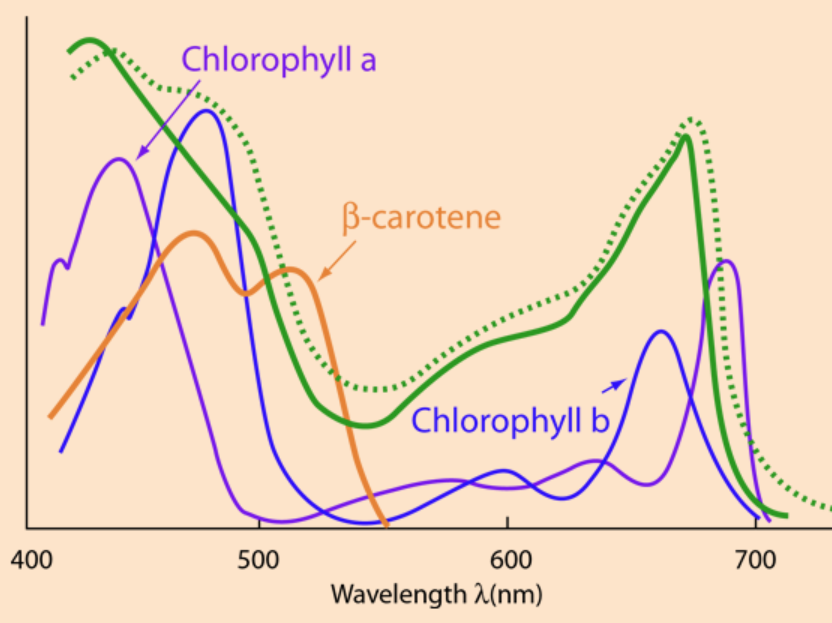

1. Can we convert the neurons to 'features' such as point values and ratios, or something similar that is more understandable?
2. Can we highlight these with lines, boxes, shaded regions?
3. Can we create a metric for each 'feature'?

In [ ]:
def plot_class_with_activation(max_neurons=4, smooth=True, plot_all_spectra = True, normalize_spectra=True, show_chlorophyl=True, lines_on_peaks=True):
    
    for idx in [[0,1],[1,0]]:
    
        # parameters for smoothing the neurons
        sigma = 10
        window = 20
        
        # Compute the mean spectrum for this class
        #class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
        # Compute the index in Y_labels for the name of this class
        #name_index = np.where(Y_labels==class_name)[0] 
        name_index = idx[0]
        # Determine the indices for the neurons in the first layer that are active for this class
        neuron_indices = np.where(np.abs(active_weights_2[name_index,:].flatten())>0)[0] 
        # Determine the amount of activation (weights in second layer) for this class
        neuron_activation = active_weights_2[name_index,neuron_indices]

        c = plt.rcParams['axes.prop_cycle'].by_key()['color'] # list of the default matplotlib colors
        
        fig, ax1 = plt.subplots(figsize=(16,8))       
        
        # shade background the plot based on the neuron
        neuronACt = neuron_activation[0]*active_weights_1[neuron_indices[0],:].flatten()
        neuronACt = scipy.ndimage.gaussian_filter1d(neuronACt, sigma)
        neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
        neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
        neuronACt = neuronACt-np.min(neuronACt)
        neuronACt = neuronACt/np.max(neuronACt)
        bkrnd = np.zeros((1000,len(wl)))
        for i in range(1000):
            bkrnd[i,:] = neuronACt 
        ax1.imshow(bkrnd, extent=[wl[0], wl[-1], 0, 1], aspect='auto', origin='lower', zorder=-1)
        
        # plot spectra from both classes
        for class_name, color in zip([Y_labels[idx[0]], Y_labels[idx[1]]], ['tab:red','tab:blue']):
            # plot class mean for alternative class
            class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
            ax1.plot(wl, normalize_spec(class_mean, normalize_spectra), color=color, lw=2, label=f'Mean Reflectance, {class_name}')
            # plot each spectra in the alternative class
            if plot_all_spectra:
                for i in np.where(name==class_name)[0]:
                    ax1.plot(wl, normalize_spec(spectra[i,:], normalize_spectra), color=color, lw=0.25, alpha=0.5)
                
        ax1.set_xlabel('Wavelength (nm)', fontsize=15) # first axis, for the spectrum
        ax1.set_ylabel('Reflectance', color='k', fontsize=15)
        ax1.tick_params(axis='y', labelcolor='k')
        plt.grid(False)
        plt.legend(loc='upper left', bbox_to_anchor=(0.56,1))

        ax2 = ax1.twinx()  # second axes, for neruon weights
        ax2.set_ylabel('Neuron Weight', color='k', fontsize=15) 
        ax2.plot([np.min(wl)-50,np.max(wl)+50], [0,0], color='k', alpha=0.25, lw=2)
        for i,n_i in enumerate(neuron_indices):
            color_index = (i+1) % (len(c)-1) # pick the next color looping through the list
            neuronACt = neuron_activation[i]*active_weights_1[n_i,:].flatten()
            if smooth:
                neuronACt = scipy.ndimage.gaussian_filter1d(neuronACt, sigma)
                neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
                neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
            ax2.plot(wl, neuronACt, color=c[color_index], lw=1, label='Active Neuron '+str(n_i))
            if lines_on_peaks:
                peaks, _ = find_peaks(neuronACt, rel_height=0.05, width=10)
                for peak_index in peaks:
                    plt.axvline(x=wl[peak_index], color='#0033cc')
                peaks, _ = find_peaks(-neuronACt, rel_height=0.05, width=10)
                for peak_index in peaks:
                    plt.axvline(x=wl[peak_index], color='#cc0066')
            if i == max_neurons-1:
                break
        
        ax2.tick_params(axis='y', labelcolor='k')
        ax2.grid(False)

        for class_name, color in zip([Y_labels[idx[0]], Y_labels[idx[1]]], ['tab:red','tab:blue']):
            # plot class mean for alternative class
            class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
            ax1.plot(wl, normalize_spec(class_mean, normalize_spectra), color=color, lw=2)
        plt.title(f'Activation Analysis for '+class_name.replace('_', ' '), fontsize=25)
        plt.xlim(np.min(wl)-50,np.max(wl)+50)
        
        if show_chlorophyl:            
            # Values from https://rseco.org/content/122-chlorophyll-absorption-and-photosynthetic-action-spectra.html
            plt.axvline(x=429, color='#02eb38', lw=0.5)
            plt.axvline(x=659, color='#02eb38', label='Chlorophyl a', lw=0.5)
            plt.axvline(x=455, color='#60a882', lw=0.5)
            plt.axvline(x=642, color='#60a882', label='Chlorophyl b', lw=0.5)
 
        
        plt.legend()
        fig.tight_layout()  
        plt.savefig('output/activation_'+class_name+'.png');
        plt.show()
        
        #plt.figure()
        #plt.imshow(bkrnd)

plot_class_with_activation(max_neurons=1, plot_all_spectra = False, smooth=True)

In [ ]:
bkrnd = np.zeros((1000,len(wl)))
for i in range(1000):
    bkrnd[i,:] = neuronACt

In [ ]:
plt.plot(neuronACt)

In [ ]:
plt